In [1]:
import os, sys
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from mitequinox.sigp import *
from mitequinox.plot import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(cores=6, walltime='01:00:00')
w = cluster.scale(6*20)

/home/uz/yux/.conda/envs/equinox/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.135.39.22:44929 Dashboard: http://10.135.39.22:34753/status,Cluster Workers: 120 Cores: 720 Memory: 999.60 GB


__________
# Ratio

In [6]:
E_dir = '/work/ALT/swot/aval/syn/xy/momentum_balance/daily/'

F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
du_dt = xr.concat([xr.open_zarr(E_dir+'du_dt_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
dv_dt = xr.concat([xr.open_zarr(E_dir+'dv_dt_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
f_u = xr.concat([xr.open_zarr(E_dir+'fu_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
f_v = xr.concat([xr.open_zarr(E_dir+'fv_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
zeta_u = xr.concat([xr.open_zarr(E_dir+'zeta_u_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
zeta_v = xr.concat([xr.open_zarr(E_dir+'zeta_v_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
dKEdx = xr.concat([xr.open_zarr(E_dir+'dKE_dx_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
dKEdy = xr.concat([xr.open_zarr(E_dir+'dKE_dy_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
detadx = xr.concat([xr.open_zarr(E_dir+'deta_dx_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
detady = xr.concat([xr.open_zarr(E_dir+'deta_dy_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
residuals_u = xr.concat([xr.open_zarr(E_dir+'residuals_u_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
residuals_v = xr.concat([xr.open_zarr(E_dir+'residuals_v_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')

dudt = du_dt.du_dt
dvdt = dv_dt.dv_dt
fu = f_u.fu
fv = f_v.fv
zeta_u = zeta_u.zeta_u
zeta_v = zeta_v.zeta_v
dKE_dx = dKEdx.dKE_dx
dKE_dy = dKEdy.dKE_dy
deta_dx = detadx.deta_dx
deta_dy = detady.deta_dy
residuals_u = residuals_u.residuals_u
residuals_v = residuals_v.residuals_v

In [8]:
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for face in F:
    
    f_ageo = np.sqrt( ((-fv.isel(face=face)+deta_dx.isel(face=face))**2).mean(['time']) + ((fu.isel(face=face)+deta_dy.isel(face=face))**2).mean(['time'])  )
    acceleration = np.sqrt( (dudt.isel(face=face)**2).mean(['time']) + (dvdt.isel(face=face)**2).mean(['time']) )
    nonlinear_advection = np.sqrt( ((-zeta_v.isel(face=face)+dKE_dx.isel(face=face))**2).mean(['time']) + ((zeta_u.isel(face=face)+dKE_dy.isel(face=face))**2).mean(['time']) )
    residuals = np.sqrt( (residuals_u.isel(face=face)**2).mean(['time']) + (residuals_v.isel(face=face)**2).mean(['time']) )
    DuDt = np.sqrt( ((dudt.isel(face=face)-zeta_v.isel(face=face)+dKE_dx.isel(face=face))**2).mean(['time']) + ((dvdt.isel(face=face)+zeta_u.isel(face=face)+dKE_dy.isel(face=face))**2).mean(['time']) )
    DuDt_residuals = np.sqrt( ((dudt.isel(face=face)-zeta_v.isel(face=face)+dKE_dx.isel(face=face)-residuals_u.isel(face=face))**2).mean(['time']) + ((dvdt.isel(face=face)+zeta_u.isel(face=face)+dKE_dy.isel(face=face)-residuals_v.isel(face=face))**2).mean(['time']) )
    
    f_ageo = np.real(f_ageo).rename('f_ageo')
    acceleration = np.real(acceleration).rename('acceleration')
    nonlinear_advection = np.real(nonlinear_advection).rename('nonlinear_advection')
    residuals = np.real(residuals).rename('residuals')
    DuDt = np.real(DuDt).rename('DuDt')
    DuDt_residuals = np.real(DuDt_residuals).rename('DuDt_residuals')
    
    rms = xr.merge([f_ageo, acceleration, nonlinear_advection, residuals, DuDt, DuDt_residuals])
    #print(rms)
    Efile = E_dir+'rms_f%02d.zarr'%face
    rms.to_zarr(Efile, mode='w')
    print('--- face %d done'%face)

--- face 0 done
--- face 1 done
--- face 2 done
--- face 3 done
--- face 4 done
--- face 5 done
--- face 6 done
--- face 7 done
--- face 8 done
--- face 9 done
--- face 10 done


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


--- face 11 done


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


--- face 12 done


In [6]:
E_dir = '/work/ALT/swot/aval/syn/xy/momentum_balance/daily/'

F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
rms = xr.concat([xr.open_zarr(E_dir+'rms_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')

acceleration = rms.acceleration
nonlinear_advection = rms.nonlinear_advection
residuals = rms.residuals
DuDt = rms.DuDt
f_ageo = rms.f_ageo

In [7]:
ds_ice = xr.open_zarr(work_data_dir+'xy/sea_ice_mask.zarr')
dij=4 
ice = ds_ice.AREA.isel(i=slice(0,None,dij), j=slice(0,None,dij)) 

In [8]:
deep_depth = 2000

DuDt_normalised = (DuDt.where(ice>0)/f_ageo.where(ice>0)).stack(point=['face','j', 'i']).chunk({'point': 100000})
DuDt_normalised_zonmean = (DuDt_normalised.where(DuDt_normalised.Depth>deep_depth).groupby_bins(DuDt_normalised['YC'], np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['point']))

residuals_normalised = (residuals.where(ice>0)/f_ageo.where(ice>0)).stack(point=['face','j', 'i']).chunk({'point': 100000})
residuals_normalised_zonmean = (residuals_normalised.where(residuals_normalised.Depth>deep_depth).groupby_bins(residuals_normalised['YC'], np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['point']))

In [12]:
DuDt_normalised_zonmean

<xarray.DataArray (YC_bins: 121)>
dask.array<stack, shape=(121,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * YC_bins  (YC_bins) int64 -60 -59 -58 -57 -56 -55 -54 ... 55 56 57 58 59 60

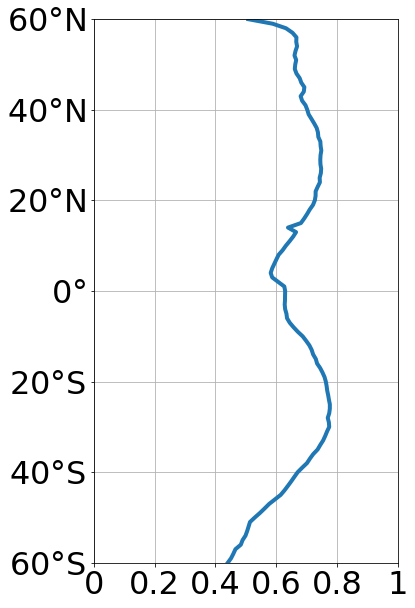

In [23]:
font_size=32

fig, ax = plt.subplots(figsize=(12,10))

ax = plt.subplot(121)
DuDt_normalised_zonmean.plot(y='YC_bins',label=r'$\frac{\langle D \vec{u}/D t \rangle_{rms}}{\langle f \times \vec{u}_a \rangle_{rms}}$', linewidth=4) # total energy
#ax.legend(prop={'size': 36}); 
ax.grid()
# x,y ticks
ax.set_ylim(-60, 60)
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_xlim([0,1])
#ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_xticks([0,0.2,0.4,0.6,0.8,1])
ax.set_xticklabels(['0','0.2','0.4','0.6','0.8','1'])
# Label, size
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)

plt.savefig('/home/uz/yux/mit_equinox/hal/Geostrophy_assessment/Figures/Figure_3a.png')

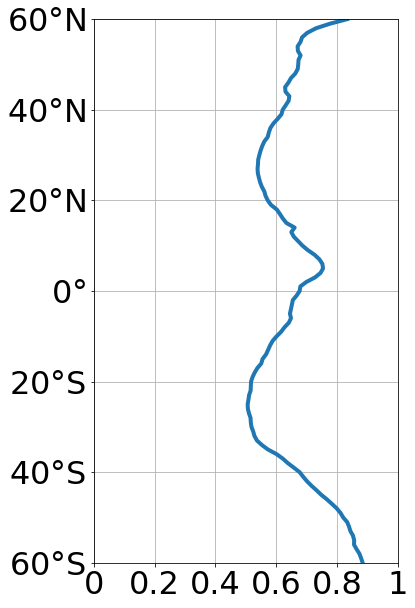

In [25]:
font_size=32

fig, ax = plt.subplots(figsize=(12,10))

ax = plt.subplot(121)
residuals_normalised_zonmean.plot(y='YC_bins',label=r'$\frac{\langle \vec{R} \rangle_{rms}}{\langle f \times \vec{u}_a \rangle_{rms}}$', linewidth=4) # total energy
#ax.legend(prop={'size': 36}); 
ax.grid()
# x,y ticks
ax.set_ylim(-60, 60)
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_xlim([0,1])
ax.set_xticks([0,0.2,0.4,0.6,0.8,1])
ax.set_xticklabels(['0','0.2','0.4','0.6','0.8','1'])
# Label, size
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)

plt.savefig('/home/uz/yux/mit_equinox/hal/Geostrophy_assessment/Figures/Figure_3b.png')

In [7]:
deep_depth = 2000

accerlation_normalised = (acceleration.where(ice>0)/f_ageo.where(ice>0)).stack(point=['face','j', 'i']).chunk({'point': 100000})
accerlation_normalised_zonmean = (accerlation_normalised.where(accerlation_normalised.Depth>deep_depth).groupby_bins(accerlation_normalised['YC'], np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['point']))

nonlinear_advection_normalised = (nonlinear_advection.where(ice>0)/f_ageo.where(ice>0)).stack(point=['face','j', 'i']).chunk({'point': 100000})
nonlinear_advection_normalised_zonmean = (nonlinear_advection_normalised.where(nonlinear_advection_normalised.Depth>deep_depth).groupby_bins(nonlinear_advection_normalised['YC'], np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['point']))

residuals_normalised = (residuals.where(ice>0)/f_ageo.where(ice>0)).stack(point=['face','j', 'i']).chunk({'point': 100000})
residuals_normalised_zonmean = (residuals_normalised.where(residuals_normalised.Depth>deep_depth).groupby_bins(residuals_normalised['YC'], np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['point']))

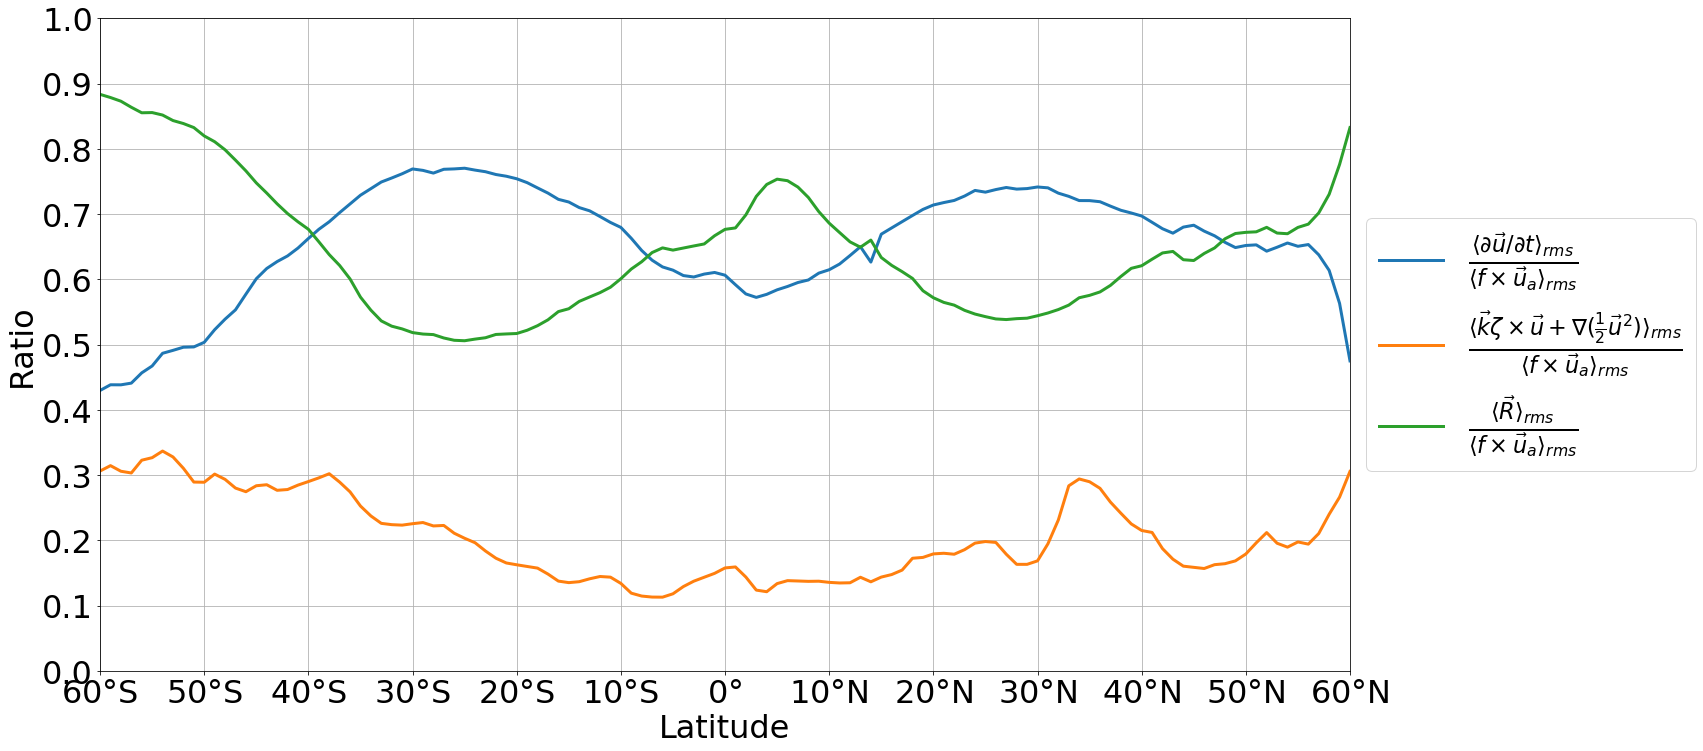

In [9]:
font_size=32

fig, ax = plt.subplots(figsize=(28,12))

accerlation_normalised_zonmean.plot(label=r'$\frac{\langle \partial \vec{u}/\partial t \rangle_{rms}}{\langle f \times \vec{u}_a \rangle_{rms}}$', linewidth=3) # total energy
nonlinear_advection_normalised_zonmean.plot(label=r'$ \frac{\langle \vec{k} \zeta \times \vec{u} + \nabla (\frac{1}{2}\vec{u}^2) \rangle_{rms}}{\langle f \times \vec{u}_a \rangle_{rms}}$', linewidth=3) # total energy
residuals_normalised_zonmean.plot(label=r'$\frac{\langle \vec{R} \rangle_{rms}}{\langle f \times \vec{u}_a \rangle_{rms}}$', linewidth=3) # total energy
ax.legend(prop={'size': 36}); 
ax.grid()

# x,y ticks
ax.set_xlim(-60, 60)
ax.set_xticks([-60,-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50,60])
ax.set_xticklabels(['$60\degree$S','$50\degree$S','$40\degree$S','$30\degree$S','$20\degree$S','$10\degree$S','$0\degree$','$10\degree$N','$20\degree$N','$30\degree$N','$40\degree$N','$50\degree$N','$60\degree$N'])
ax.set_ylim([0,1])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

# Label, size
ax.set_xlabel('Latitude',fontsize=font_size)
ax.set_ylabel('Ratio',fontsize=font_size)
ax.tick_params(labelsize=font_size)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': font_size})

plt.savefig('/home/uz/yux/mit_equinox/hal/Geostrophy_assessment/Figures/Figure_3.png')

In [26]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/uz/yux/.conda/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/uz/yux/.conda/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1276, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/uz/yux/.conda/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/uz/yux/.conda/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1005, in _reconnect
    await self._close()
  File "/home/uz/yux/.conda/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1276, in _close
    await gen.with_timeout(timedelta(seconds=